### 整体步骤
1. 导入数据
2. 数据预处理
3. 构建G和D网络
4. 建立训练过程
5. 训练
6. 保存模型

### 导入相关包

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import os
import time
import glob
import matplotlib.pyplot as plt
from IPython import display


In [2]:
tf.__version__

'2.2.0'

In [3]:
# 检查GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 加载数据集

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
# reshape
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
# 像素值调整到[-1,1]
train_images = (train_images - 127.5) / 127.5

In [7]:
# 打印数据集大小
train_images.shape

(60000, 28, 28, 1)

In [8]:
# 批次
BATCH_SIZE = 256

In [9]:
# 构造dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

In [10]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

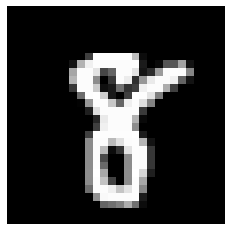

In [48]:
# 预览数据集

for x in train_dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 + 127.5 )[0],cmap='gray')
    break


In [1]:
# 网络架构

![](./data/model_arc.png)

### 生成器模型

In [11]:
# 构建生成器

G_model = tf.keras.Sequential([
    # 输入向量
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)) ,
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # reshape
    layers.Reshape((7, 7, 256)) , #  7x7x256
    #  use_bias=False
    layers.Conv2DTranspose(128, 5, 1,  padding='same' ,use_bias=False), # 7 x 7 x 128
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # 上采样 
    layers.Conv2DTranspose(64, 5,2, padding='same' , use_bias=False), # 14 x 14 x 64
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # 缩小通道数
    layers.Conv2DTranspose(1, 5, 2, padding='same', use_bias=False, activation='tanh') # 28 x 28 x 1

])



In [12]:
# 打印网络架构
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### 随机噪声生成一张

In [ ]:
# 随机噪声向量
noise = tf.random.normal([1, 100])
# 输入网络
generated_image = G_model(noise, training=False)
# 显示
plt.imshow(generated_image[0], cmap='gray')

### 判别器模型



In [14]:
# 构建一个 CNN 的图片分类器。
D_model = tf.keras.Sequential([
    # 下采样
    layers.Conv2D(64, 5, 2, padding='same',input_shape=[28, 28, 1]),  # 14 x 14 x 64
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # 下采样
    layers.Conv2D(128, 5, 2, padding='same'), # 7 x 7 x 128
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # 拉直
    layers.Flatten(),
    # 判别
    layers.Dense(1) # 1
])


In [15]:
D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

使用未训练的D对所生成的图像进行分类。真实图像输出正值，伪造图像输出负值。

In [16]:
# 将刚才随机生成的输入D网络查看输出结果
decision = D_model(generated_image)
print (decision)

tf.Tensor([[0.499211]], shape=(1, 1), dtype=float32)


## 定义损失函数和优化器

In [17]:
# 使用BCE LOSS函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# 优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 定义训练循环


In [49]:
# 装饰函数以便被调用
@tf.function
def train_step(images):
    
    # 训练判别器
    # 为了记录计算过程，使用梯度带GradientTape
    with tf.GradientTape() as tape:
        # 前传，真实样本判别输出
        real_output = D_model(images, training=True)
        # 构造label
        ones_label = tf.ones_like(real_output)
        # 计算loss
        disc_loss = cross_entropy(ones_label,real_output)
    # 计算梯度    
    gradients_of_discriminator = tape.gradient(disc_loss, D_model.trainable_variables)
    #优化模型，反向传递
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D_model.trainable_variables))
    
    with tf.GradientTape() as tape:
        # 随机噪音
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        # 前传，伪造的图片
        generated_images = G_model(noise, training=True)
        # 前传，伪造图片的判别输出
        fake_output = D_model(generated_images, training=True)
        # label
        zeros_label = tf.zeros_like(fake_output)
        # 计算loss
        disc_loss = cross_entropy( zeros_label,fake_output)
    # 梯度
    gradients_of_discriminator = tape.gradient(disc_loss, D_model.trainable_variables)
    # 优化模型，反向传递
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D_model.trainable_variables))
    
    # 训练生成器
    with tf.GradientTape() as tape:
         # 随机噪音
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        # 产生的图片
        generated_images = G_model(noise, training=True)
        # 生成图片的判别输出
        fake_output = D_model(generated_images, training=True)
        # label
        ones_label = tf.ones_like(fake_output)
        # 计算loss
        gen_loss = cross_entropy(ones_label,fake_output )
    # 梯度    
    gradients_of_generator = tape.gradient(gen_loss, G_model.trainable_variables)
    # 优化模型，反向传递
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G_model.trainable_variables))


In [20]:
# 开始训练

In [21]:

EPOCHS = 200
# 输入维度
noise_dim = 100
#希望产生样本数量
num_examples_to_generate = 16
# 随机正态分布噪声
noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

第1个Epoch训练时间:20.03965973854065 s


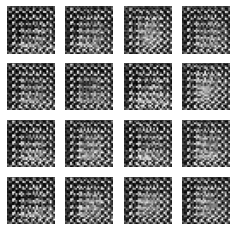

第2个Epoch训练时间:17.828113555908203 s


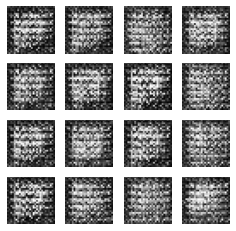

第3个Epoch训练时间:17.707879066467285 s


第199个Epoch训练时间:17.730615615844727 s


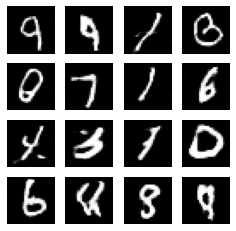

第200个Epoch训练时间:17.648266553878784 s


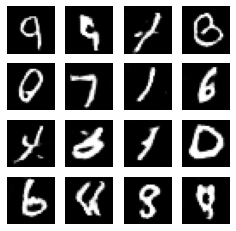

In [ ]:
# 开始训练
for epoch in range(EPOCHS):
    # 遍历dataset
    start_time = time.time()
    for imgs_batch in train_dataset:
        # 训练
        train_step(imgs_batch)
        
    print('第{}个Epoch训练时间:{} s'.format(epoch+1,time.time()-start_time))
    # 显示当前G可以产生的画面，并保存
    predictions = G_model(noise_seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i] *127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('gen_minist/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [26]:

# 保存模型
G_model.save('./data/minist_G_model')

INFO:tensorflow:Assets written to: ./data/minist_G_model\assets
